# 基于Pandas和Matplotlib实现的模型网络指标对比图工具

# 1、项目背景

最近在梳理手头工作，回顾去年整个虎年，堪称YOLO内卷元年，各路YOLO系列神仙打架，各显神通。

一开始大部分用户做项目做实验还是使用的YOLOv5，然后YOLOv6、YOLOv7、PP-YOLOE+、DAMO-YOLO、RTMDet就接踵而至，

于是就在自己的数据集逐一尝试，好不容易把这些下饺子式的YOLO模型训练完测试完，忙完工作准备回家过年时，YOLOv8又闪电发布，YOLOv6又更新了3.0版本...用户还得跟进继续训练测试，其实很多时候就是重复工作。

此外换模型训练调参也会引入更多的不确定性，而且往往业务数据集大则几十万张图片，重训成本很高，但训完了新的精度不一定更高，速度指标在特定机器环境上也未必可观，参数量、计算量的变化尤其在边缘设备上也不能忽视。

所以在这样的内卷期，作为开发者，或者研究者的我们，应该怎么样去做一个关于不同网络模型结构的性能结果对比呢？

刚好那段时间的契机是，在折腾[**YOLOv8_Efficient**](https://github.com/isLinXu/YOLOv8_Efficient)这个项目，拿到了YOLOv8的模型权重，于是就准备开始动手做这么一个工具。

最后处理完的结果，大概是这个样子。
如下图。
![](https://ai-studio-static-online.cdn.bcebos.com/f95f4ccbaec444ac915c19f37cdfba9eb90e11a78f6e4ad6a1f085a7c4c4f7f6)


# 2、初步的想法

其实动手做这个项目最初的想法是，希望能够做一个绘制多个神经网络模型性能指标的一个对比图工具，

发现很多论文作者都会选择用python程序来做一个图形绘制，但自己去github上到处找了一圈，也在各个群里问了一遍都没有找到比较合适的工具。

似乎他们都是直接用list存储数据丢到matplotlib里面来做专门的图形绘制，最后还是决定动手去撸一个工具，来满足自己的需求。

# 3、设计与选型

考虑到开发语言使用的是Python，那么作为主流的**Matplotlib**库便成为了作为绘制图像的优先选择。

在引入了Matplotlib之后，简单地学习使用了它的一些绘制工具和用法，就开始试着去各个开源repo和YOLO系列的论文下面把主要关心的几个维度给记录下来，然后保存到python的list数组里面去，再传给Matplotlib去绘制图形。但是随之而来的问题是，每个模型系列都包括着不同的分支，且对应着不同的指标参数，同时最终还需要将不同的模型系列下的不同分支也做一个对比，就相当于是不仅要对比不同模型系列的性能指标，还需要将同一模型下的不同分支也做一个对比。例如Yolov5下面就有n、s、m、l、x等多个分支。

因此，结合之前做数据分析处理的经验，意识到可以自己定义数据结构来满足Matplotlib的参数输入，那么如何设计多个模型指标参数的数据结构就成为一个思考的问题，又考虑到多模型多分支的因素，于是建立了下面这张表格。
* 用**model**来区分不同模型
* 用**branch**来区分同一模型下的不同分支
* 用**ms**和**fps**以及**mAP**作为绘图的指标参数
* 用**maker**来区分绘制图例的标识符号
* 以及用**release date**、**data source**作为一个数据来源的记录

![](https://ai-studio-static-online.cdn.bcebos.com/0dfacba7b4eb425f947100832ba37e00cddd090ab19341419d50c9b4a745d787)

将记录完成的数据，整理保存为**.CSV**文件，自然而然的，后面引入了Pandas来做一个数据处理和读取的工具。

至此，这个绘图小工具的设计与选型基本完成。

最后还需要加(亿)一点点小细节！

* 关于速度的统一，这里需要做fps与ms之间的转换。例如yolov6对于网络模型推理速度的指标为fps，而yolov5的指标则是直接用ms来进行评价。

实现方式是用math来进行转换计算
```python
def fps_to_ms(fps: int) -> int:
    '''
    Convert FPS to a millisecond interval.
    Args:
        fps: Input FPS as integer.
    Returns:
        Interval in milliseconds as integer number.
    '''
    return math.floor((1 / fps) * 1000)
```

* 例如标题名称，横轴、纵轴的名称，以及网格等多个变量的定义与需要，都需要进行自定义输入。

目前支持修改和调整的参数如下，数据格式可以参考上面的介绍。

```python
def parse_opt(known=False):
    parser = argparse.ArgumentParser(description="Quick use model-metrics-plot")
    parser.add_argument('-c', '--csv', default='data/Pytorch_models_data.csv', help="csv path")
    parser.add_argument('-n', '--fig_path', default='output/plot_metrics.jpg', help="figure path")
    parser.add_argument('-p', '--plot_type', default='line', help="i.e line, bar, scatter")
    parser.add_argument('-t', '--title_name', default='MS COCO Object Detection', help="title name")
    parser.add_argument('-x', '--xlabel_name', default='PyTorch FP16 RTX3080(ms/img)', help="xlabel name")
    parser.add_argument('-y', '--ylabel_name', default='COCO Mask AP val', help="ylabel name")
    parser.add_argument('-g', '--is_grid', default=False, help="is grid")
    parser.add_argument('-f', '--font_size', default=10, help="font_size")
    parser.add_argument('-v', '--value_type', default='mAP', help="value type,i.e mAP, FPS, ms")
    parser.add_argument('-r', '--colors', default='#0000FF', help="colors")

    return parser.parse_known_args()[0] if known else parser.parse_args()
```


于是开始了漫长的调试与测试....

但是仅能绘制模型的速度和精度显然是不够，同时绘制折线图也有一定的局限性。
于是又引入了条形图，来辅助绘制单个指标参数的模型性能对比。

![](https://ai-studio-static-online.cdn.bcebos.com/5fcb3535a13f4676922eb23875113ff95db4e2112239493e9d3257959cc15d42)



终于在某个周末的早上，把所有的数据和实例都跑通了。

目前代码已开源在Github，链接为：https://github.com/isLinXu/model-metrics-plot

![](https://ai-studio-static-online.cdn.bcebos.com/71c61ec19747470f89e6c22c22876622ea96a7177ccb47a6930b191aa10ed25c)

![](https://ai-studio-static-online.cdn.bcebos.com/4a63655be7e54a629346cac3f86cb56ff41a3f4013724b4083e666ef962102a4)




# 4、动手体验

上面讲了那么多有的没的废话，talk is cheap,show me the code，不妨直接来动手实操一下。

目前数据已上传到本项目的work目录下，可自行参考修改或创建自己的数据表。

项目代码也开源到github上了，直接clone下来即可。

本来是打算上传到pypi的源仓库，让大家直接pip install来安装使用的，后面发现想到的比较好的名字全部都被注册占用了。

于是没办法，大家还是直接软链接的形式来安装使用吧。

最后，大家觉得好用的话，欢迎给本项目打Star和forks，谢谢大家的支持。

## 4.1配置安装

### 4.1.1 克隆仓库

In [1]:
!git clone https://github.com/isLinXu/model-metrics-plot.git

正克隆到 'model-metrics-plot'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 242 (delta 5), reused 13 (delta 3), pack-reused 225
接收对象中: 100% (242/242), 2.98 MiB | 1.65 MiB/s, 完成.
处理 delta 中: 100% (108/108), 完成.
检查连接... 完成。


In [2]:
%cd model-metrics-plot

/home/aistudio/model-metrics-plot


In [3]:
!ls

configs  LICENSE  mmplot_test.py  README.md	    setup.cfg
data	 main.py  output	  README.zh-CN.md   setup.py
img	 mmplot   plots		  requirements.txt  utils


###  4.1.2 依赖安装

In [4]:
!pip install -e .

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Obtaining file:///home/aistudio/model-metrics-plot
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmplot

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
!pip install omegaconf

## 4.2 测试使用

### 4.2.1 引入mmplot库

In [6]:
import mmplot

### 4.2.2 绘制多模型指标折线对比图

In [14]:
import pandas 
csv_path = '/home/aistudio/work/PaddleYOLO_model_data.csv'
df = pandas.read_csv(csv_path)
df

,model,branch,ms,fps,mAP,maker
0,YOLOv5,n,2.6,-1,28.0,.
1,YOLOv5,s,3.2,-1,37.6,.
2,YOLOv5,m,5.2,-1,45.4,.
3,YOLOv5,l,7.9,-1,48.9,.
4,YOLOv5,x,13.7,-1,50.6,.
5,YOLOv6,n,1.3,-1,36.1,.
6,YOLOv6,t,2.1,-1,40.7,.
7,YOLOv6,s,2.6,-1,43.4,.
8,YOLOv6,m,5.0,-1,49.0,.
9,YOLOv6,l,7.9,-1,51.0,.


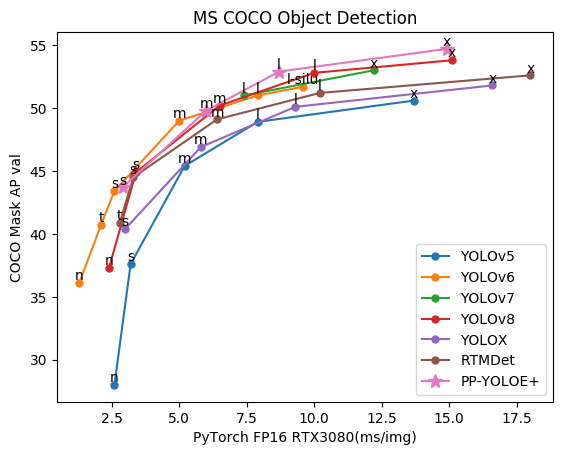

In [8]:
%matplotlib inline
from mmplot.plots import plot_metrics
from mmplot.utils.dataloader import pd_read_csv

if __name__ == '__main__':
    csv_path = '/home/aistudio/work/PaddleYOLO_model_data.csv'
    fig_path = 'plot_metrics.jpg'
    df = pd_read_csv(csv_path)
    plot_metrics(df, fig_path)

### 4.2.3 绘制多模型指标条形对比图

In [15]:
import pandas 
csv_path = '/home/aistudio/work/MMYOLO_model_data.csv'
df = pandas.read_csv(csv_path)
df

,model,branch,ms,fps,mAP
0,YOLOv5,n,-1,-1,28.0
1,YOLOv5,s,-1,-1,37.7
2,YOLOv5,m,-1,-1,45.3
3,YOLOv5,l,-1,-1,48.8
4,YOLOv6,n,-1,-1,36.2
5,YOLOv6,t,-1,-1,41.0
6,YOLOv6,s,-1,-1,44.0
7,YOLOv6,m,-1,-1,48.4
8,YOLOv6,l,-1,-1,51.0
9,YOLOv7,tiny,-1,-1,37.5


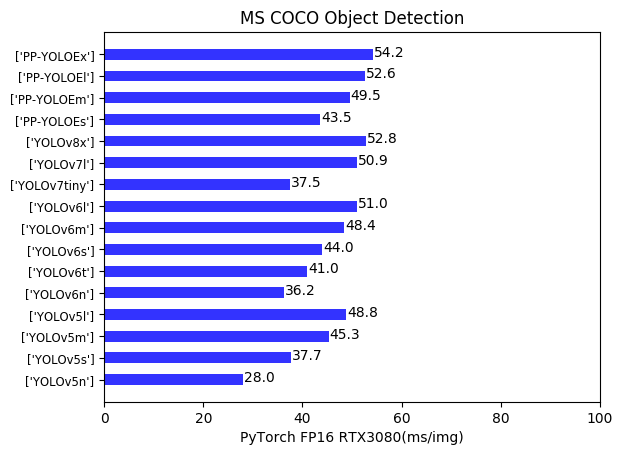

In [13]:
%matplotlib inline
from mmplot.utils.dataloader import pd_read_csv
from plots.bar_chart_plot import bar_chart_plot
from plots.line_metrics_plots import plot_metrics
if __name__ == '__main__':
    csv_path = '/home/aistudio/work/MMYOLO_model_data.csv'
    fig_path = 'plot_line_metrics.jpg'
    title_name = 'MS COCO Object Detection'
    xlabel_name = 'PyTorch FP16 RTX3080(ms/img)'
    colors = '#0000FF'
    value_type = 'mAP'
    is_grid = False
    df = pd_read_csv(csv_path)
    bar_chart_plot(df, fig_path, value_type, title_name, xlabel_name, colors, is_grid)

# 5、总结

自己造轮子是一件很折腾，但也很有意思的事情。

可以培养自己除了开发之外，关于产品和用户角度的一些思维。

关于这个工具，后续也会引入和支持更多的绘图方式来辅助算法选型和科研需要。

最后，也在PFCC的推荐下，给PaddleYOLO和PaddleDetection提交了相应的PR，目前已被合入，后面又做了微调。


# 6、个人介绍

* 林旭 某小厂算法架构师
* AICA六期班学员
* 飞桨PFCC成员
* 飞桨PPDE
* Github主页:https://github.com/isLinXu
* AI Studio主页：https://aistudio.baidu.com/aistudio/personalcenter/thirdview/777989